In [1]:
%load_ext autoreload
%autoreload 2
from lightglue import LightGlue, SuperPoint
from lightglue.utils import load_image, match_pair
from lightglue import viz2d
from pathlib import Path
import torch
import time
images = Path('uavimg')

In [2]:
extractor = SuperPoint(max_num_keypoints=2048, nms_radius=3).eval().cuda()  # load the extractor
match_conf = {
    'width_confidence': 0.99,  # for point pruning
    'depth_confidence': 0.95,  # for early stopping,
}
matcher = LightGlue(pretrained='superpoint', **match_conf).eval().cuda()

Loaded SuperPoint model
Loaded LightGlue model


108.81614685058594


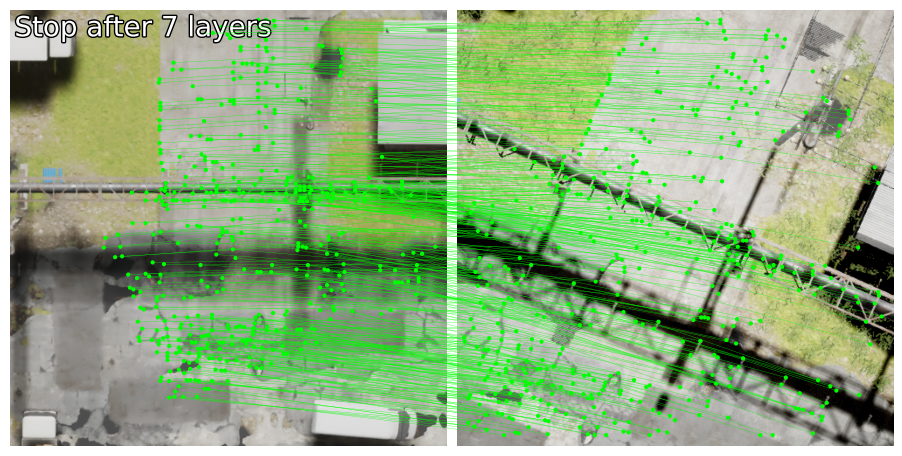

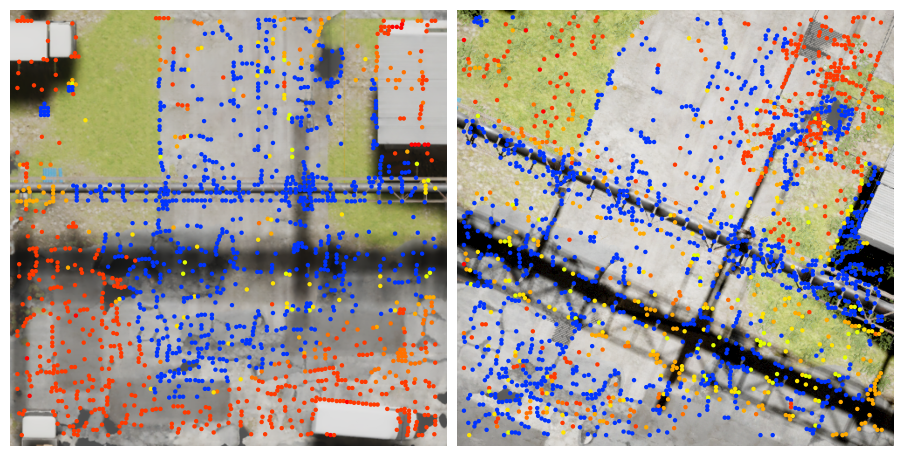

In [7]:
# image0, scales0 = load_image(images / 'satellite.png', resize=512, grayscale=False)
# image1, scales1 = load_image(images / 'uav.png', resize=512, grayscale=False)

image0, scales0 = load_image(images / 'satellite.png', grayscale=False)
image1, scales1 = load_image(images / 'uav.png', grayscale=False)

t1 = time.time()
pred = match_pair(extractor, matcher, image0, image1)
t2 = time.time()

kpts0, kpts1, matches = pred['keypoints0'], pred['keypoints1'], pred['matches']
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0.permute(1, 2, 0), image1.permute(1, 2, 0)])
viz2d.plot_matches(m_kpts0, m_kpts1, color='lime', lw=0.2)
viz2d.add_text(0, f'Stop after {pred["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(pred['prune0']), viz2d.cm_prune(pred['prune1'])
viz2d.plot_images([image0.permute(1, 2, 0), image1.permute(1, 2, 0)])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)
print((t2 - t1) * 1000)

436


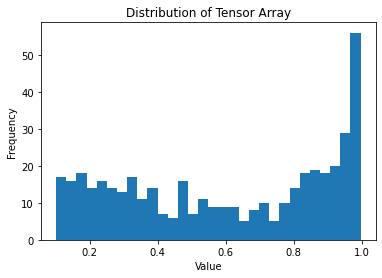

In [14]:
import matplotlib.pyplot as plt

matching_scores = pred['matching_scores']
print(len(matching_scores))

plt.hist(matching_scores, bins=30)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Tensor Array')
plt.show()

In [41]:
scores = matching_scores.numpy()
print(scores.mean())

0.60228777


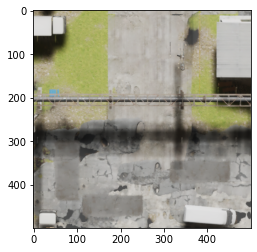

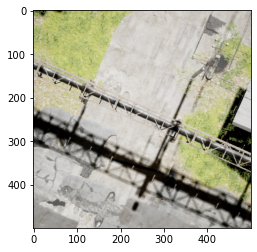

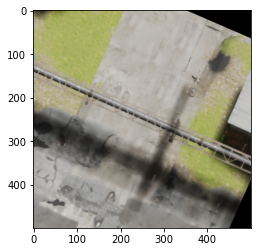

In [38]:
import cv2 

H, _ = cv2.findHomography(m_kpts0.numpy(), m_kpts1.numpy(), cv2.RANSAC, 5.0)


plt.imshow(image0.permute(1,2,0))
plt.show()
plt.imshow(image1.permute(1,2,0))
plt.show()


image2 = cv2.warpPerspective(image0.permute(1,2,0).numpy(), H, (image1.permute(1,2,0).shape[1], image1.permute(1,2,0).shape[0]))
plt.imshow(image2)
plt.show()